In [2]:
import pandas as pd 
import numpy as np

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.datasets import fetch_openml

In [5]:
mnist_Df = fetch_openml('mnist_784',version = 1)

In [6]:
mnist_Df.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X = mnist_Df['data']
Y = mnist_Df['target']

Now let's try to plot out a random number from our dataset

In [8]:
some_digit = np.array(X.iloc[4])

## Reshaping an array of 784 element into 28 x 28 array 
some_digit_image = some_digit.reshape(28,28)

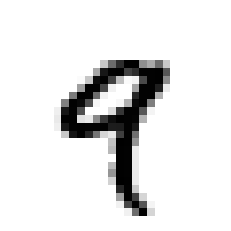

In [9]:
plt.imshow(some_digit_image, cmap = "binary")
plt.axis('off')
plt.show()

This looks like a 9 let's cross check it with out target value

In [10]:
Y[4]

'9'

It indeed is 9. We can notice that that the target value is in string format and majority of ML algorithm require int type data for training purpose. So we'll convert it into the required data type.

In [11]:
Y = Y.astype(np.uint8)

Before further analyzing our data we need to seperate our data set and keep it aside. Since in the description it is mentioned that this dataset is already split into test and train datasets all we need to do is seperatly assign it to the variables.

In [12]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],Y[:60000],Y[60000:]

In [13]:
X_train.shape

(60000, 784)

In [14]:
y_train.shape

(60000,)

First let's try creating a binary classifier for our random digit.

## Binary Classifier
9 detector

In [15]:
from sklearn.linear_model import SGDClassifier

In [16]:
### when we use SGD optimiser it applies SVM classifier by default
sgd_clf = SGDClassifier(random_state=42)

In [17]:
y_train_9 = (y_train == 9)

In [18]:
y_train_9

0        False
1        False
2        False
3        False
4         True
         ...  
59995    False
59996    False
59997    False
59998    False
59999    False
Name: class, Length: 60000, dtype: bool

In [19]:
sgd_clf.fit(X_train,y_train_9)

SGDClassifier(random_state=42)

In [20]:
sgd_clf.predict([some_digit])

array([ True])

In [21]:
from sklearn.model_selection import cross_val_score,cross_val_predict

In [22]:
### When we use a int/none for cv and estimator is performing binary or multiclass classification Stratified K is used
cross_val_score(estimator=sgd_clf,X=X_train,y=y_train_9,cv=3,scoring='accuracy')

array([0.9456 , 0.95195, 0.9509 ])

**Accuracy of 95% seems like our classifier is nearly perfect. But let's check it with a very dumb classifier which predicts always predicts image as not 9.**

In [23]:
from sklearn.base import BaseEstimator

In [24]:
class dumb_classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1),dtype = bool)

In [26]:
never_5 = dumb_classifier()

In [27]:
dumb_score = cross_val_score(estimator=never_5,X=X_train,y=y_train_9,cv=3,scoring='accuracy')

In [28]:
dumb_score

array([0.8993 , 0.8999 , 0.90335])

**Nearly 90% accuracy. This shows that 9 makes up 10% of our data set so if we always classify as not 9 we will be right 90% of time. Thus accuracy is not the right model evaluation technique.**

In [29]:
y_train_9.value_counts()

False    54051
True      5949
Name: class, dtype: int64

In [97]:
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_9,cv=5)

In [33]:
from sklearn.metrics import confusion_matrix,classification_report

In [36]:
confusion_matrix(y_train_9,y_train_pred)

array([[52715,  1336],
       [ 1695,  4254]])

In [98]:
print(classification_report(y_train_9,y_train_pred))

              precision    recall  f1-score   support

       False       0.97      0.97      0.97     54051
        True       0.72      0.74      0.73      5949

    accuracy                           0.95     60000
   macro avg       0.84      0.86      0.85     60000
weighted avg       0.95      0.95      0.95     60000



**When our classifier claims an image represents a 9, it is correct only 72% of the time. Moreover, it only detects 74% of the 9s.**

### Precision Recall Curve

**Let's try to improve the precision of our Stochastic gradient classifier by determining the appropriate threshold value buy drawing precision recall curve.**

In [38]:
y_train_score = cross_val_predict(sgd_clf,X_train,y_train_9,cv=3,method='decision_function')

In [72]:
y_train_score

array([-23009.36445429, -18436.99768895, -15940.48683084, ...,
       -30278.93992241, -28156.99780661,  -6860.27399688])

In [39]:
from sklearn.metrics import precision_recall_curve

In [40]:
precision, recall, thresholds = precision_recall_curve(y_train_9, y_train_score)

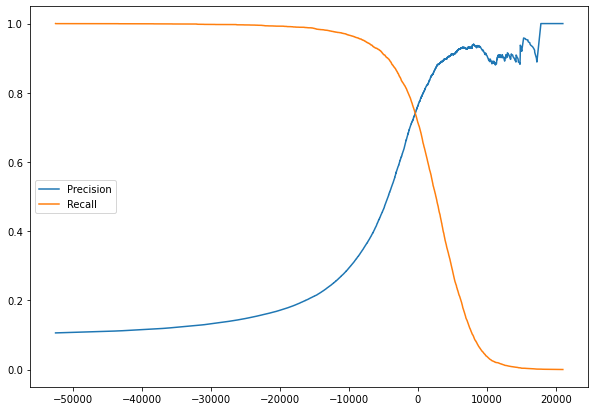

In [58]:
plt.figure(figsize=(10,7))
plt.plot(thresholds,precision[:-1], label = 'Precision')
plt.plot(thresholds,recall[:-1],label = 'Recall')
plt.legend(loc = "center left")
plt.show()

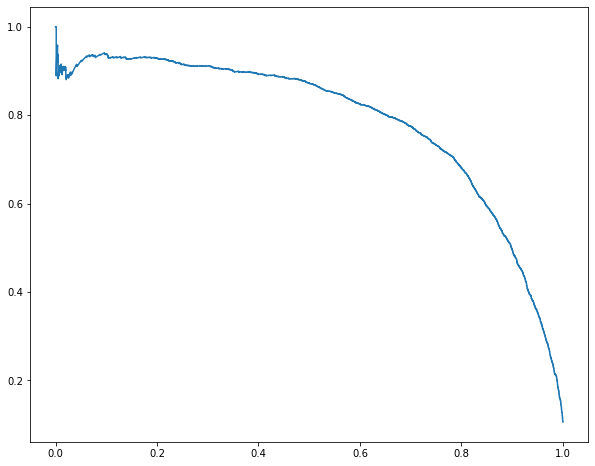

In [60]:
plt.figure(figsize=(10,8))
plt.plot(recall,precision)

In [66]:
max_thresh = thresholds[np.argmax(precision>=0.90)]

In [67]:
max_thresh

4255.5613542876035

In [68]:
y_train_pred_90 = (y_train_score > max_thresh)

In [69]:
print(classification_report(y_train_9,y_train_pred_90))

              precision    recall  f1-score   support

       False       0.93      1.00      0.96     54051
        True       0.90      0.35      0.50      5949

    accuracy                           0.93     60000
   macro avg       0.92      0.67      0.73     60000
weighted avg       0.93      0.93      0.92     60000



We were successfully able to achieve 90% precision for our model but our recall is extreamly low 

### ROC Curve

In [78]:
from sklearn.metrics import roc_curve,roc_auc_score

In [74]:
fpr, tpr, threshold = roc_curve(y_train_9,y_train_score)

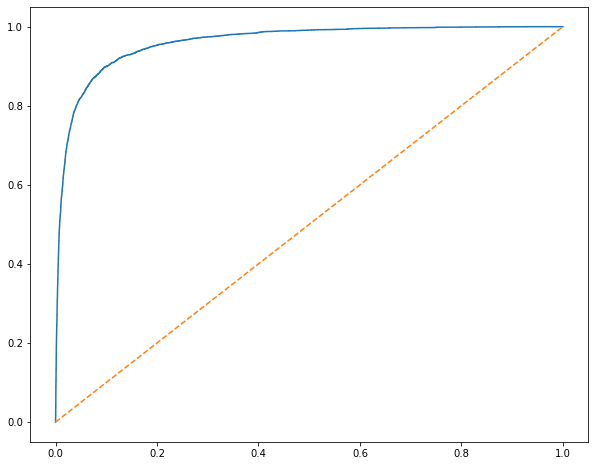

In [77]:
plt.figure(figsize=(10,8))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'--')

In [79]:
roc_auc_score(y_train_9,y_train_score)

0.96114559368217

**A good model/classifier has area under curve = 1 our model's area is close to one but we should try other classifier which might have aoc closer to 1.**

In [80]:
from sklearn.ensemble import RandomForestClassifier

In [81]:
rfc = RandomForestClassifier(random_state=42)

In [82]:
rfc_scores = cross_val_predict(rfc,X_train,y_train_9,cv=3,method='predict_proba')

In [88]:
rfc_9_score = rfc_scores[:,1]

**Looks like aoc value for a random forest classifier is closer to one compared to our stocastic gradient decent classifier based on support vector machine**

In [89]:
roc_auc_score(y_train_9,rfc_9_score)

0.9952328942154235

In [90]:
rfc_predict = cross_val_predict(rfc,X_train,y_train_9,cv=3)

In [91]:
print(classification_report(y_train_9,rfc_predict))

              precision    recall  f1-score   support

       False       0.98      1.00      0.99     54051
        True       0.98      0.84      0.91      5949

    accuracy                           0.98     60000
   macro avg       0.98      0.92      0.95     60000
weighted avg       0.98      0.98      0.98     60000



## Multiclass Classification

**Let's first try our classification model with cross validation data and then use the most suitable model to make prediction on our final test set**

In [92]:
rfc_multi_score = cross_val_predict(rfc,X_train,y_train,cv = 5)

In [94]:
print(classification_report(y_train,rfc_multi_score))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5923
           1       0.98      0.98      0.98      6742
           2       0.96      0.97      0.96      5958
           3       0.96      0.95      0.95      6131
           4       0.96      0.97      0.97      5842
           5       0.97      0.96      0.96      5421
           6       0.98      0.98      0.98      5918
           7       0.97      0.96      0.97      6265
           8       0.95      0.95      0.95      5851
           9       0.95      0.95      0.95      5949

    accuracy                           0.97     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.97      0.97      0.97     60000



In [95]:
sgd_multi_pred = cross_val_predict(sgd_clf,X_train,y_train,cv = 5)

In [96]:
print(classification_report(y_train,sgd_multi_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      5923
           1       0.93      0.96      0.95      6742
           2       0.88      0.86      0.87      5958
           3       0.87      0.84      0.86      6131
           4       0.88      0.88      0.88      5842
           5       0.83      0.81      0.82      5421
           6       0.92      0.94      0.93      5918
           7       0.91      0.89      0.90      6265
           8       0.81      0.80      0.80      5851
           9       0.82      0.84      0.83      5949

    accuracy                           0.88     60000
   macro avg       0.88      0.88      0.88     60000
weighted avg       0.88      0.88      0.88     60000



Clearly random forest classifier is much better for the classification purpose as it provides high precision for each class as well as good precision.

In [100]:
rfc.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [102]:
rfc_prediction  = rfc.predict(X_test)

In [103]:
print(classification_report(y_test,rfc_prediction))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### Finall Report on our random forest classification model looks good!!